In [20]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [21]:
G = pickle.load(open('graphs/graph.pkl','rb'))

Edge Features

1) Product Group
2) Product Sub-Group
3) Plant
4) Storage Location

Node Features

1) Production
2) Factory Issue
3) Sales Order
4) Delivery to distributor

- 5 groups
- 19 subgroups
- 25 plants
- 13 storage locations

<h4>Product Groups and Sub-Groups<h4/>

In [22]:
product_groups = pd.read_csv('Raw Dataset/Homogenoeus/Nodes/Node Types (Product Group and Subgroup).csv')
product_groups.head()

,Node,Group,Sub-Group
0,SOS008L02P,S,SOS
1,SOS005L04P,S,SOS
2,SOS003L04P,S,SOS
3,SOS002L09P,S,SOS
4,SOS001L12P,S,SOS


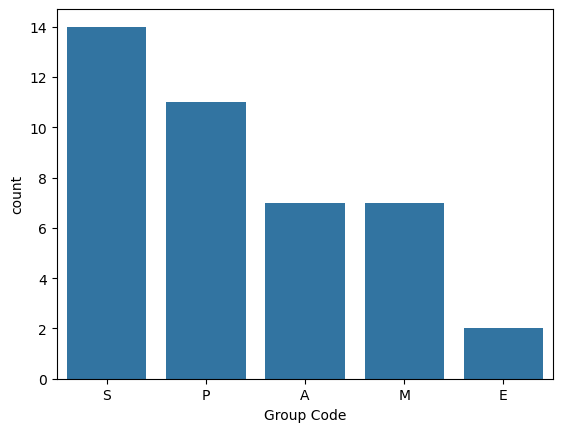

In [23]:
sns.barplot(product_groups['Group'].value_counts(),errorbar=('ci', False))
plt.xlabel('Group Code');

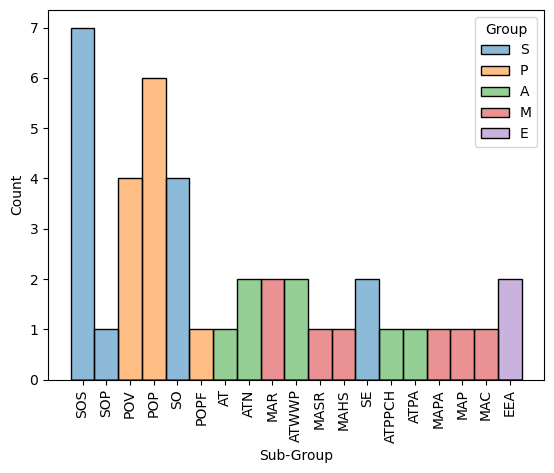

In [24]:
sns.histplot(product_groups,x='Sub-Group',hue='Group',)
plt.xticks(rotation=90);

<h4>Edge Demographics</h4>

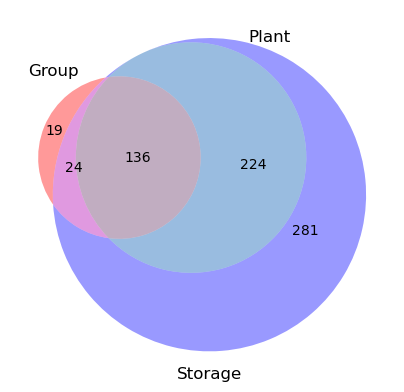

In [25]:
from matplotlib_venn import venn3
group_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['GroupCode'] > 0] )
subgroup_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['SubGroupCode'] > 0] )
plant_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['Plant'] > 0] )
storage_set = set([i for i,t in enumerate(G.edges(data=True))if t[2]['Storage Location'] > 0] )

venn3([group_set,plant_set,storage_set],['Group','Plant','Storage']);

- This venn diagram represents all 684 edges.
- Every product that shares atleast one plant also shares atleast one storage location.

In [26]:
edges_df = pd.DataFrame([
    [d['GroupCode'] for u,v,d in G.edges(data=True)],
    [d['Plant'] for u,v,d in G.edges(data=True)],
    [d['Storage Location'] for u,v,d in G.edges(data=True)],
],index=['GroupCode','Plant','Storage Location']).T

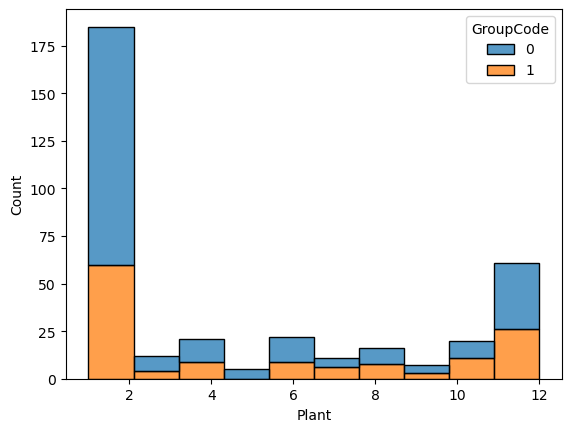

In [27]:
sns.histplot(data=edges_df[edges_df['Plant'] > 0],x='Plant',hue='GroupCode',multiple='stack');

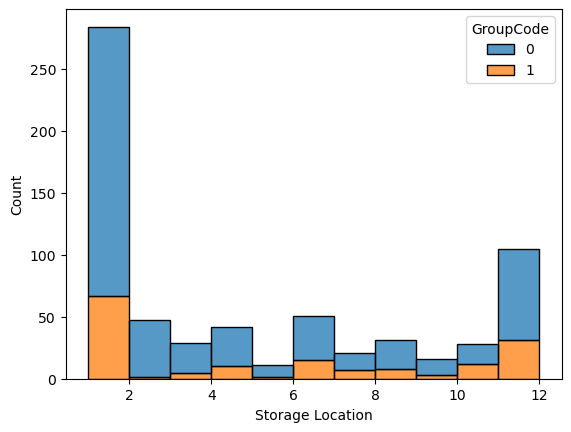

In [28]:
sns.histplot(data=edges_df[edges_df['Storage Location'] > 0],x='Storage Location',hue='GroupCode',multiple='stack');

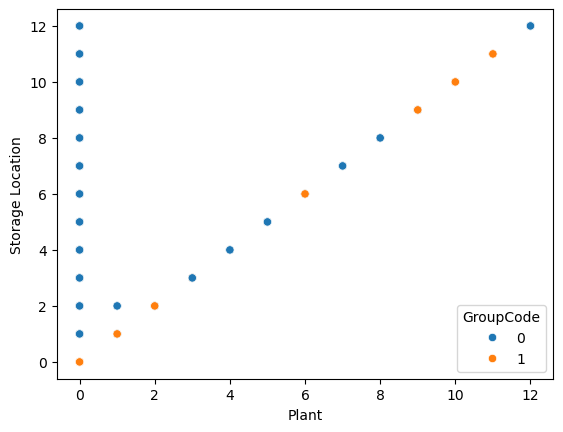

In [29]:
sns.scatterplot(data=edges_df,x='Plant',y='Storage Location',hue='GroupCode');

- Products that go to the same plants also go to the same storage locations which makes sense.
- It also looks like Storage Locations take products from different plants. some product(s) share 12 storage locations without sharing a plant or group

<h4>Node Connectedness

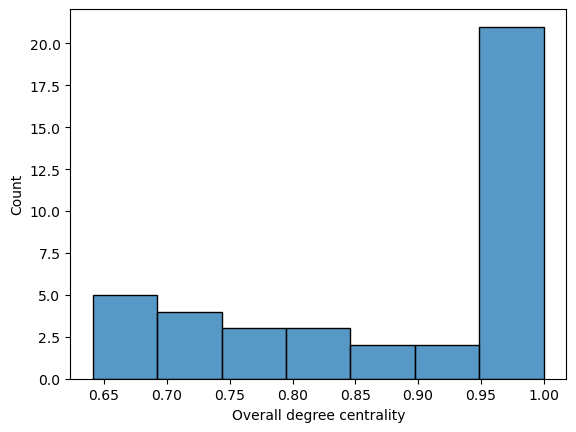

In [30]:
degree_cents = nx.degree_centrality(G)

sns.histplot(list(degree_cents.values()))
plt.xlabel('Overall degree centrality');

In [31]:
for n, d in G.nodes(data=True):
    G.nodes[n]["degree"] = nx.degree(G, n)

<h4/>Plants and Storage Locations<h4/>

In [32]:
color_mapping = {     
    'S':'blue',
    'P':'orange',
    'A':'green',
    'M':'red',
    'E':'purple'
}

for n in G.nodes():
    G.nodes.data()[n]['color'] = color_mapping[G.nodes.data()[n]['GroupCode']]

In [33]:
G_plants = nx.Graph()
G_plants.add_nodes_from(G.nodes(data=True))
G_plants.add_edges_from([(node1,node2,md) for node1,node2,md in G.edges(data=True) if md['Plant'] > 0])

In [34]:
G_storage = nx.Graph()
G_storage.add_nodes_from(G.nodes(data=True))
G_storage.add_edges_from([(node1,node2,md) for node1,node2,md in G.edges(data=True) if md['Storage Location'] > 0])


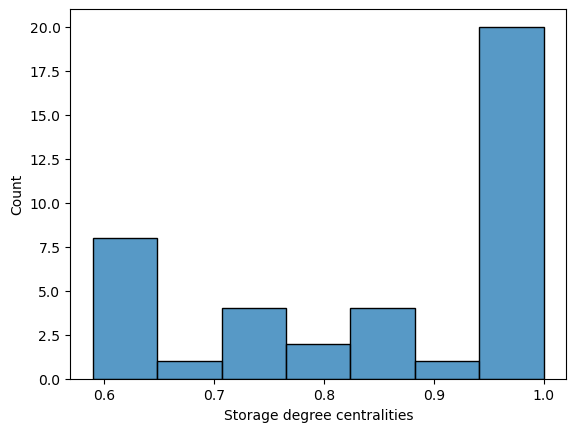

In [35]:
degree_cents = nx.degree_centrality(G_storage)
sns.histplot(list(degree_cents.values()))
plt.xlabel('Storage degree centralities');

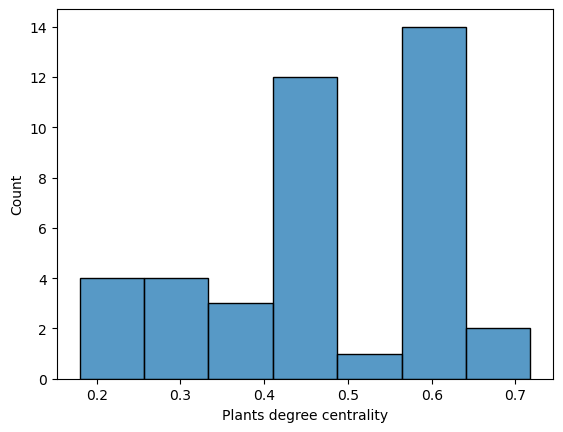

In [36]:
degree_cents = nx.degree_centrality(G_plants)
sns.histplot(list(degree_cents.values()))
plt.xlabel('Plants degree centrality');

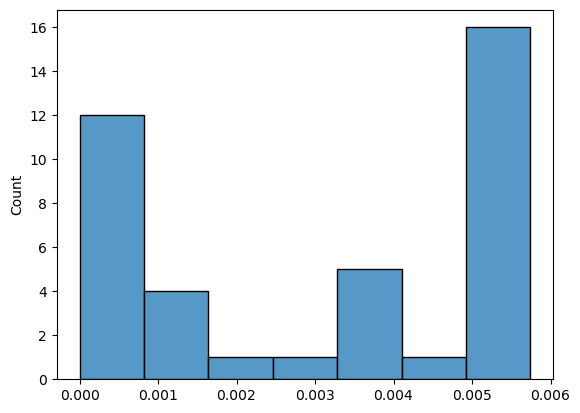

In [37]:
bet_cent = nx.betweenness_centrality(G)
sns.histplot(list(bet_cent.values()));

The betweenness centrality is generally low, and degree centrality generally high, because most of the possible edges exist. 40 choose 2 is 780 and there are 684 edges

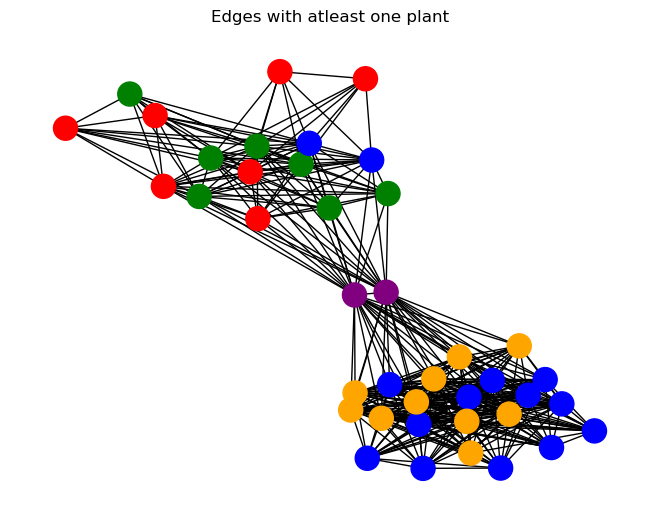

In [41]:
node_colors = nx.get_node_attributes(G_plants, "color").values()
colors = list(node_colors)

nx.draw(G_plants,node_color=colors)
plt.title('Edges with atleast one plant');

# product groups = {     couldn't figure out how to add a legend 
#     'S':'blue',
#     'P':'orange',
#     'A':'green',
#     'M':'red',
#     'E':'purple'
# };

- It seems like like that groups M and A share plants while groups S and P share plants
- Group E with only 2 products shares plants with all the groups